In [1]:
# data analysis
import numpy as np
import pandas as pd
import sys

# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [8,6]

# load the 'Population' object for simulation
from imp import reload
import stochasticgrowth_eventline as sge
sge = reload(sge)

In [2]:
# least mean squares estimator with covariance/error matrix

def LMSQ(x,y):
    n   = len(x)
    sx  = np.sum(x)
    sy  = np.sum(y)
    sxx = np.dot(x,x)
    sxy = np.dot(x,y)
    syy = np.dot(y,y)
    
    denom  = (n*sxx-sx*sx)
    b      = (n*sxy - sx*sy)/denom
    a      = (sy-b*sx)/n
    estim  = np.array([a,b],dtype=np.float)

    sigma2 = syy + n*a*a + b*b*sxx + 2*a*b*sx - 2*a*sy - 2*b*sxy
    cov    = sigma2 / denom * np.array([[sxx,-sx],[-sx,n]],dtype=np.float)

    return estim,cov

In [3]:
# run several simulations for different initial sizes
# (takes a few minutes to execute)

# store everything in single dictionary
sim = dict()


for initialsize in [10**i for i in range(3)]:
    sim[initialsize] = list()
    for runID in range(5):
        # append a new Population object at the end of the list ...
        sim[initialsize].append(sge.Population(initialpopulationsize = initialsize))
        # ... then run it for 10000 division events
        sim[initialsize][-1].growth(divisionevents = 10000)

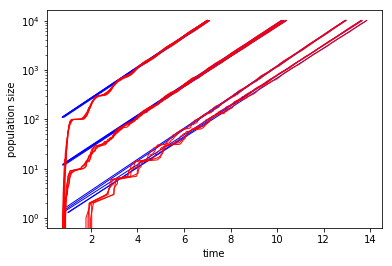

In [4]:
# analyze data

# first, check simple growth curves and compare with exponential fits of growth

for initialsize in sim.keys():
    for run in sim[initialsize]:
        data = run.divisiondata

        t  = np.array(data['times'])
        s  = np.array(data['populationsize'])
        dt = np.array(data['divisiontimes'])

        # fit only for time > 4
        growthrate_fit,cov = LMSQ(t[t>4],np.log(s[t>4]))

        # PLOT: size over time
        plt.plot(t,s, c = 'red', zorder = 2, lw = 1)
        # PLOT: exponential fit
        plt.plot(t,np.exp(growthrate_fit[0] + growthrate_fit[1]*t), c = 'blue', zorder=1,lw = 1)

plt.yscale('log')
plt.xlabel('time')
plt.ylabel('population size')
plt.show()

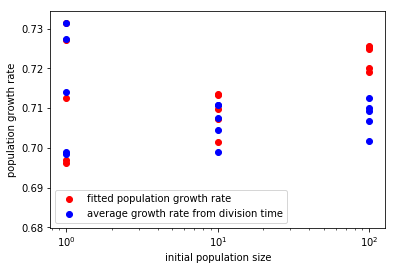

In [5]:
# more analysis, check average growth rate from as inverse of (single cell) division times to the global population growth rate

# outcome: variance between simulation runs much higher for smaller inoculum sizes!

for initialsize in sim.keys():
    for run in sim[initialsize]:
        data = run.divisiondata
        
        t  = np.array(data['times'])
        s  = np.array(data['populationsize'])
        dt = np.array(data['divisiontimes'])
        
        # fit only after time > 4
        growthrate_fit,cov = LMSQ(t[t>4],np.log(s[t>4]))
        
        # PLOT: initialsize vs fitted population growth rate
        plt.scatter([initialsize],[growthrate_fit[1]],c = 'red')
        # PLOT: initial size vs 
        plt.scatter([initialsize],[np.log(2)/np.mean(dt[t>4])],c = 'blue')

plt.xscale('log')
plt.xlabel('initial population size')
plt.ylabel('population growth rate')
plt.legend(['fitted population growth rate','average growth rate from division time'])
plt.show()